In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline
pd.set_option('display.max_columns', 100)

In [2]:
modelo=pd.read_csv('data/modelo.csv',low_memory=False)

In [3]:
modelo.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
modelo.shape

(2341681, 23)

In [5]:
modelo.isnull().sum()

timestamp                         0
event                             0
person                            0
url                         2150550
sku                         1021151
model                       1020168
condition                   1021151
storage                     1021151
color                       1021151
skus                        1835732
search_term                 2227918
staticpage                  2330480
campaign_source             2150395
search_engine               2235275
channel                     2137612
new_vs_returning            2137612
city                        2137612
region                      2137612
country                     2137612
device_type                 2137612
screen_resolution           2137615
operating_system_version    2137612
browser_version             2137612
dtype: int64

In [6]:
modelo.drop(['url', 'sku', 'skus','channel','staticpage','condition','search_engine','device_type','campaign_source','country','region','search_term','new_vs_returning','city','region','screen_resolution','operating_system_version','browser_version'], axis=1, inplace=True)

In [7]:
training= pd.read_csv('data/training.csv',low_memory=False)

# Armado del modelo

In [8]:
import calendar
modelo['timestamp'] = pd.to_datetime(modelo['timestamp'])

### Fechas

In [9]:
modelo['dia']=modelo['timestamp'].dt.dayofyear
modelo['dia_de_la_semana']=modelo['timestamp'].dt.dayofweek
modelo['nombre_del_dia']=modelo['timestamp'].dt.day_name()
modelo['hora']=modelo['timestamp'].dt.hour

### Horas distintas

In [10]:
modelo['horas_distintas']=modelo['person'].map(modelo.groupby('person')['hora'].nunique())

### Eventos en los ultimos dias

### Tipos de eventos por persona

In [11]:
df_aux=modelo.groupby(['person','event'])['event'].size().unstack('event')
modelo=pd.merge(modelo,df_aux,on='person',how='left')

### Dias distintos en el ultimo mes

In [12]:
modelo['dias_distintos'] = modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month==5) ] )['dia'].nunique().unstack()[True]) 

In [13]:
modelo['dias_distintos_ultima_semana']=modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month==5)&(modelo['timestamp'].dt.day>23) ] )['dia'].nunique().unstack()[True])  

### Dias distintos de la semana

In [14]:
modelo['dias_distintos_de_la_semana']=modelo['person'].map(modelo.groupby('person')['dia_de_la_semana'].nunique())    

In [15]:
modelo['dias_distintos_de_la_semana_last_month']=modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month==5) ])['dia_de_la_semana'].nunique().unstack()[True])

### Ultima visita

In [16]:
modelo['ultima_visita']=modelo['person'].map(modelo.groupby('person' )['dia'].max())  

### Compras por dia de la semana

In [17]:
df_aux=modelo.groupby(['person','nombre_del_dia']).size().reset_index()
compras_por_dia_semana=modelo.loc[modelo['event']=='conversion']['nombre_del_dia'].value_counts().to_dict()
df_aux['compras_por_dia_semana']=df_aux[0]*df_aux['nombre_del_dia'].apply(lambda x: compras_por_dia_semana.get(x))
modelo['compras_por_dia_semana']=modelo['person'].map(df_aux.groupby('person')['compras_por_dia_semana'].sum())  

### Modelos y marcas de celuares distintos vistos

In [18]:
modelo['modelos_distintos_vistos']= modelo['person'].map( modelo.groupby('person')['model'].nunique())

modelo['marca']=modelo['model'].str.split().str.get(0)
modelo['marcas_distintas']=modelo['person'].map(modelo.groupby('person')['marca'].nunique()) 

### Visitas maximas de un mismo celular

In [19]:
modelo['celular_mas_visto']=modelo['person'].map(modelo.groupby(['person','model']).size().groupby('person').max()) 

### Relacion de colores por modelo

In [20]:
modelo['color']=modelo['color'].fillna(0)
modelo['modelos_por_color']=modelo['person'].map(modelo.groupby('person')['model'].nunique()/(modelo.groupby('person')['color'].nunique()))

### Eventos distintos

In [21]:
modelo['eventos_distintos']=modelo['person'].map(modelo.groupby('person')['event'].nunique())   

### Relacion de eventos sobre el total del usuario

In [22]:
#df_aux = modelo.groupby(['person','event']).size().unstack().fillna(0).astype(int)
#df_aux = df_aux.div(df_aux.sum(axis=1), axis=0)
#modelo = modelo.merge(df_aux, how='left', on='person')
#modelo.head()
#df_aux.head()

### Campaña en la ultima semana

In [23]:
modelo['campaña_ultima_semana']=modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month==5) & (modelo['timestamp'].dt.day>23) & (modelo['event']=="ad campaign hit")]).size().unstack()[True]) 

### Visitas

In [24]:
modelo['total_visitas_usuario'] = modelo.groupby('person')['person'].transform('count')

modelo['visitas_ultimo_mes']=modelo['person'].map(modelo.groupby(['person',(modelo['timestamp'].dt.month)==5]).size().unstack()[True])

modelo['visitas_ultimos_15']=modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>15)]).size().unstack()[True])

modelo['visitas_ultima_semana']=modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True])

modelo['visitas_ultimos_3']=modelo['person'].map(modelo.groupby(['person', (modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>27)]).size().unstack()[True])

### Checkouts

In [25]:
modelo['total_checkout']=modelo['person'].map(modelo.groupby(['person','event']).size().unstack()['checkout'])

modelo['checkouts_ultimo_mes']=modelo['person'].map(modelo.groupby(['person','event',modelo['timestamp'].dt.month==5 ]).size().unstack()[True].unstack()['checkout'])   

modelo['checkouts_ultima_semana']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True].unstack()['checkout'])

### Compras

In [26]:
modelo['total_compras']=modelo['person'].map(modelo.groupby(['person','event']).size().unstack()['conversion'])

modelo['compras_ultimo_mes']=modelo['person'].map(modelo.groupby(['person','event',modelo['timestamp'].dt.month==5 ]).size().unstack()[True].unstack()['conversion'])

modelo['compras_ultima_semana']=modelo['person'].map(modelo.groupby(['person','event',(modelo['timestamp'].dt.month==5)& (modelo['timestamp'].dt.day>23)]).size().unstack()[True].unstack()['conversion'])

### Subscripciones

In [27]:
modelo['subscripciones']=modelo['person'].map(modelo.groupby(['person','event']).size().unstack()['lead'])

### Celulares mas vendidos

In [28]:
"""compras_por_modelo = modelo.groupby('event').get_group('conversion')['model'].value_counts().to_frame()
aux_df = modelo.groupby(['person', 'model']).size().reset_index().merge(compras_por_modelo, how='left', left_on='model', right_index=True)
aux_df['vistas_sobre_compras'] = aux_df[0] / aux_df['model_y']
aux_df = aux_df.groupby('person')['vistas_sobre_compras'].mean().reset_index()
modelo = modelo.merge(aux_df, how='left', on='person')
modelo.head()"""

"compras_por_modelo = modelo.groupby('event').get_group('conversion')['model'].value_counts().to_frame()\naux_df = modelo.groupby(['person', 'model']).size().reset_index().merge(compras_por_modelo, how='left', left_on='model', right_index=True)\naux_df['vistas_sobre_compras'] = aux_df[0] / aux_df['model_y']\naux_df = aux_df.groupby('person')['vistas_sobre_compras'].mean().reset_index()\nmodelo = modelo.merge(aux_df, how='left', on='person')\nmodelo.head()"

### Eventos por dia de la semana

In [29]:
"""dias = modelo.groupby('person')['nombre_del_dia'].value_counts().unstack().fillna(0).astype(int)
dias = dias.div(dias.sum(axis=1), axis=0)

modelo = modelo.merge(dias, how='left', on='person')
modelo.head()"""

"dias = modelo.groupby('person')['nombre_del_dia'].value_counts().unstack().fillna(0).astype(int)\ndias = dias.div(dias.sum(axis=1), axis=0)\n\nmodelo = modelo.merge(dias, how='left', on='person')\nmodelo.head()"

In [30]:
precios=pd.read_csv('precios.csv',low_memory=False)
precios['Storage'] = precios['Capacidad'].astype(str) + 'GB' 
precios['mod+stg']= precios['Model']+precios['Storage']
modelo['mod+stg']= modelo['model']+modelo['storage']
modelo=pd.merge(modelo,precios,on='mod+stg',how="outer")
modelo.drop(['mod+stg','Model','Storage','Capacidad'], axis=1,inplace=True)
modelo['Precio']=modelo['Precio'].fillna(modelo['Precio'].mean())

In [31]:
modelo['precio_max']=modelo['person'].map(modelo.groupby('person')['Precio'].max())
modelo['precio_mean']=modelo['person'].map(modelo.groupby('person')['Precio'].mean())
modelo['precio_std']=modelo['person'].map(modelo.groupby('person')['Precio'].std())
modelo['precio_min']=modelo['person'].map(modelo.groupby('person')['Precio'].min())

### Dropeo de columnas

In [32]:
modelo.drop(['color','dia','dia_de_la_semana','nombre_del_dia','model','marca','timestamp','event','hora','Precio','storage'],1,inplace=True)
modelo=modelo.drop_duplicates(subset=['person'])

In [33]:
modelo=modelo.fillna(0)

In [34]:
modelo=pd.merge(modelo, training, on='person', how='left')
modelo.iloc[:,1:-1]=modelo.iloc[:,1:-1].astype(np.int64)
modelo.head()

,person,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,total_compras,compras_ultimo_mes,compras_ultima_semana,subscripciones,precio_max,precio_mean,precio_std,precio_min,label
0,4886f805,1,0,0,1,0,1,0,1,1,0,4,1,1,0,1,1,138,8046,1,1,5,0,6,0,9,9,9,0,0,1,1,0,0,0,0,0,1275,972,287,730,NaN
1,2e225ac4,4,14,0,5,0,2,0,13,0,0,15,3,3,0,3,3,138,38860,1,1,20,0,6,0,52,52,29,0,0,5,5,0,0,0,0,0,1275,1065,267,730,0.0
2,fc278339,19,22,144,4,1,34,0,6,0,0,132,65,7,3,7,4,147,476787,38,5,21,2,8,1,408,119,105,46,0,4,1,0,1,0,0,0,3009,1253,203,319,1.0
3,0ec008ff,4,9,31,0,0,5,0,5,0,0,83,3,3,1,2,2,151,180525,35,4,9,3,6,1,136,136,127,102,102,0,0,0,0,0,0,0,2099,1224,223,399,NaN
4,4f06f2dd,4,6,3,1,0,0,0,1,0,0,31,3,2,0,2,2,142,48747,15,5,16,1,6,0,45,45,45,0,0,1,1,0,0,0,0,0,1275,1243,154,379,NaN


In [35]:
modelo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38830 entries, 0 to 38829
Data columns (total 42 columns):
person                                    38830 non-null object
horas_distintas                           38830 non-null int64
ad campaign hit                           38830 non-null int64
brand listing                             38830 non-null int64
checkout                                  38830 non-null int64
conversion                                38830 non-null int64
generic listing                           38830 non-null int64
lead                                      38830 non-null int64
search engine hit                         38830 non-null int64
searched products                         38830 non-null int64
staticpage                                38830 non-null int64
viewed product                            38830 non-null int64
visited site                              38830 non-null int64
dias_distintos                            38830 non-null int64
dias_dis

## Test de datos a predecir en Kaggle

In [36]:
a_predecir=modelo[modelo['label'].isnull()]
a_predecir.head()

,person,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,total_compras,compras_ultimo_mes,compras_ultima_semana,subscripciones,precio_max,precio_mean,precio_std,precio_min,label
0,4886f805,1,0,0,1,0,1,0,1,1,0,4,1,1,0,1,1,138,8046,1,1,5,0,6,0,9,9,9,0,0,1,1,0,0,0,0,0,1275,972,287,730,NaN
3,0ec008ff,4,9,31,0,0,5,0,5,0,0,83,3,3,1,2,2,151,180525,35,4,9,3,6,1,136,136,127,102,102,0,0,0,0,0,0,0,2099,1224,223,399,NaN
4,4f06f2dd,4,6,3,1,0,0,0,1,0,0,31,3,2,0,2,2,142,48747,15,5,16,1,6,0,45,45,45,0,0,1,1,0,0,0,0,0,1275,1243,154,379,NaN
7,b51c3897,2,0,18,1,1,3,0,3,0,0,53,1,1,1,1,1,149,111600,12,3,24,1,7,0,80,80,80,80,80,1,1,1,1,1,1,0,2229,1249,187,399,NaN
8,67ec6a13,5,0,48,0,0,18,0,0,0,0,23,9,7,2,5,5,149,94560,13,5,6,1,4,0,98,98,59,33,18,0,0,0,0,0,0,0,1959,1252,153,730,NaN


## Modelo a entrenar

In [37]:
modelo.drop(modelo[modelo['label'].isnull()].index,inplace=True)
modelo['label']=modelo['label'].astype(int)
modelo.head()

,person,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,total_compras,compras_ultimo_mes,compras_ultima_semana,subscripciones,precio_max,precio_mean,precio_std,precio_min,label
1,2e225ac4,4,14,0,5,0,2,0,13,0,0,15,3,3,0,3,3,138,38860,1,1,20,0,6,0,52,52,29,0,0,5,5,0,0,0,0,0,1275,1065,267,730,0
2,fc278339,19,22,144,4,1,34,0,6,0,0,132,65,7,3,7,4,147,476787,38,5,21,2,8,1,408,119,105,46,0,4,1,0,1,0,0,0,3009,1253,203,319,1
5,b6ff254a,4,4,0,2,0,3,0,5,3,0,21,6,3,0,3,2,138,58675,4,2,18,0,7,0,44,38,23,0,0,2,2,0,0,0,0,0,2469,1198,341,619,0
6,5cc1dc20,1,2,0,1,0,0,0,0,0,0,2,1,1,0,1,1,138,5364,1,1,3,0,4,0,6,6,6,0,0,1,1,0,0,0,0,0,1275,1002,298,730,0
13,05ad382c,2,1,1,1,0,4,0,1,2,0,12,1,1,1,1,1,149,32085,8,2,4,2,8,1,23,23,23,23,23,1,1,1,0,0,0,0,1799,1243,176,730,0


## Analisis

In [38]:
len(modelo[modelo['label']==1]),len(modelo[modelo['label']==0]) 

(980, 18434)

In [39]:
len(modelo[modelo['label']==1])*100/len(modelo['label']),len(modelo[modelo['label']==0])*100/len(modelo['label'])

(5.047903574739879, 94.95209642526012)

In [40]:
modelo[modelo['label']==1].head()

,person,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,total_compras,compras_ultimo_mes,compras_ultima_semana,subscripciones,precio_max,precio_mean,precio_std,precio_min,label
2,fc278339,19,22,144,4,1,34,0,6,0,0,132,65,7,3,7,4,147,476787,38,5,21,2,8,1,408,119,105,46,0,4,1,0,1,0,0,0,3009,1253,203,319,1
44,0d68d38e,8,11,23,4,3,10,0,5,0,1,54,8,3,2,3,2,150,159675,14,6,43,1,9,8,119,101,101,86,86,4,4,4,3,3,3,0,4000,1290,257,730,1
117,0da5ecfc,15,48,15,3,2,71,0,22,2,5,290,43,19,1,7,7,151,495050,35,6,122,1,10,1,501,366,56,12,12,3,3,0,2,2,0,0,3009,1141,461,319,1
148,acc30075,10,8,7,0,0,15,0,9,0,0,46,16,6,3,4,4,151,138725,13,3,15,1,6,5,101,101,101,66,66,0,0,0,0,0,0,0,2199,1202,263,399,1
216,c9c96c81,14,40,174,17,6,3,0,8,68,0,287,22,12,7,7,7,151,503247,41,5,57,4,9,15,625,625,589,345,143,17,17,11,6,6,4,0,1589,1246,148,399,1


In [41]:
modelo[modelo['label']==0].head()

,person,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,total_compras,compras_ultimo_mes,compras_ultima_semana,subscripciones,precio_max,precio_mean,precio_std,precio_min,label
1,2e225ac4,4,14,0,5,0,2,0,13,0,0,15,3,3,0,3,3,138,38860,1,1,20,0,6,0,52,52,29,0,0,5,5,0,0,0,0,0,1275,1065,267,730,0
5,b6ff254a,4,4,0,2,0,3,0,5,3,0,21,6,3,0,3,2,138,58675,4,2,18,0,7,0,44,38,23,0,0,2,2,0,0,0,0,0,2469,1198,341,619,0
6,5cc1dc20,1,2,0,1,0,0,0,0,0,0,2,1,1,0,1,1,138,5364,1,1,3,0,4,0,6,6,6,0,0,1,1,0,0,0,0,0,1275,1002,298,730,0
13,05ad382c,2,1,1,1,0,4,0,1,2,0,12,1,1,1,1,1,149,32085,8,2,4,2,8,1,23,23,23,23,23,1,1,1,0,0,0,0,1799,1243,176,730,0
15,c7fba740,5,12,6,1,0,6,0,6,12,0,45,4,3,2,2,2,149,128430,13,3,19,1,8,9,92,92,92,70,67,1,1,1,0,0,0,0,1299,977,275,669,0


In [42]:
modelo[modelo['label']==1].mean()-modelo[modelo['label']==0].mean()

horas_distintas                               1.790825
ad campaign hit                               1.448198
brand listing                                 6.213203
checkout                                      0.165994
conversion                                    0.275212
generic listing                               3.885751
lead                                          0.034651
search engine hit                             1.456420
searched products                             2.051567
staticpage                                    0.325931
viewed product                               23.653092
visited site                                  4.043978
dias_distintos                                0.600485
dias_distintos_ultima_semana                  0.280920
dias_distintos_de_la_semana                   0.834582
dias_distintos_de_la_semana_last_month        0.228019
ultima_visita                                -6.780611
compras_por_dia_semana                    48103.280946
modelos_di

Text(0.5, 1.0, 'Ultima visita de usuarios que compraron en los proximos 15 dias')

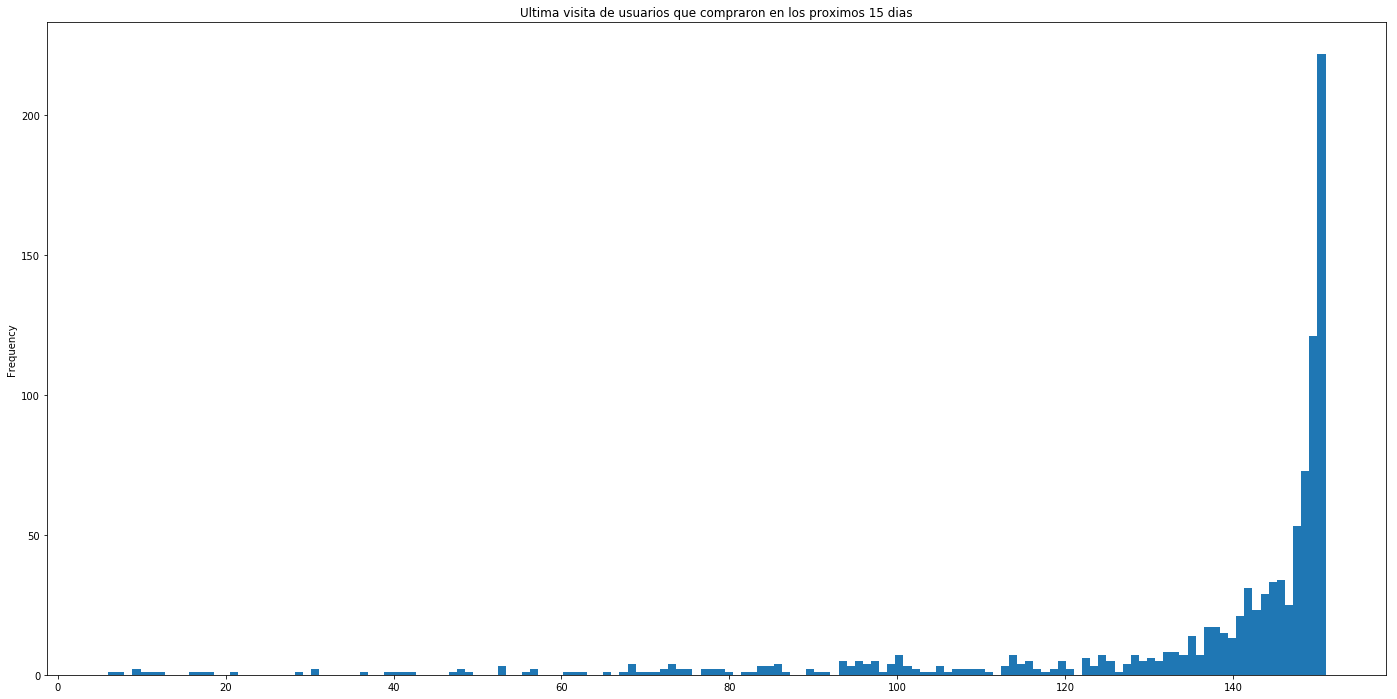

In [43]:
modelo[modelo['label']==1]['ultima_visita'].plot(kind='hist',figsize=(24,12),bins=150)
plt.title('Ultima visita de usuarios que compraron en los proximos 15 dias')

Text(0.5, 1.0, 'Ultima visita de usuarios que no compraron en los proximos 15 dias')

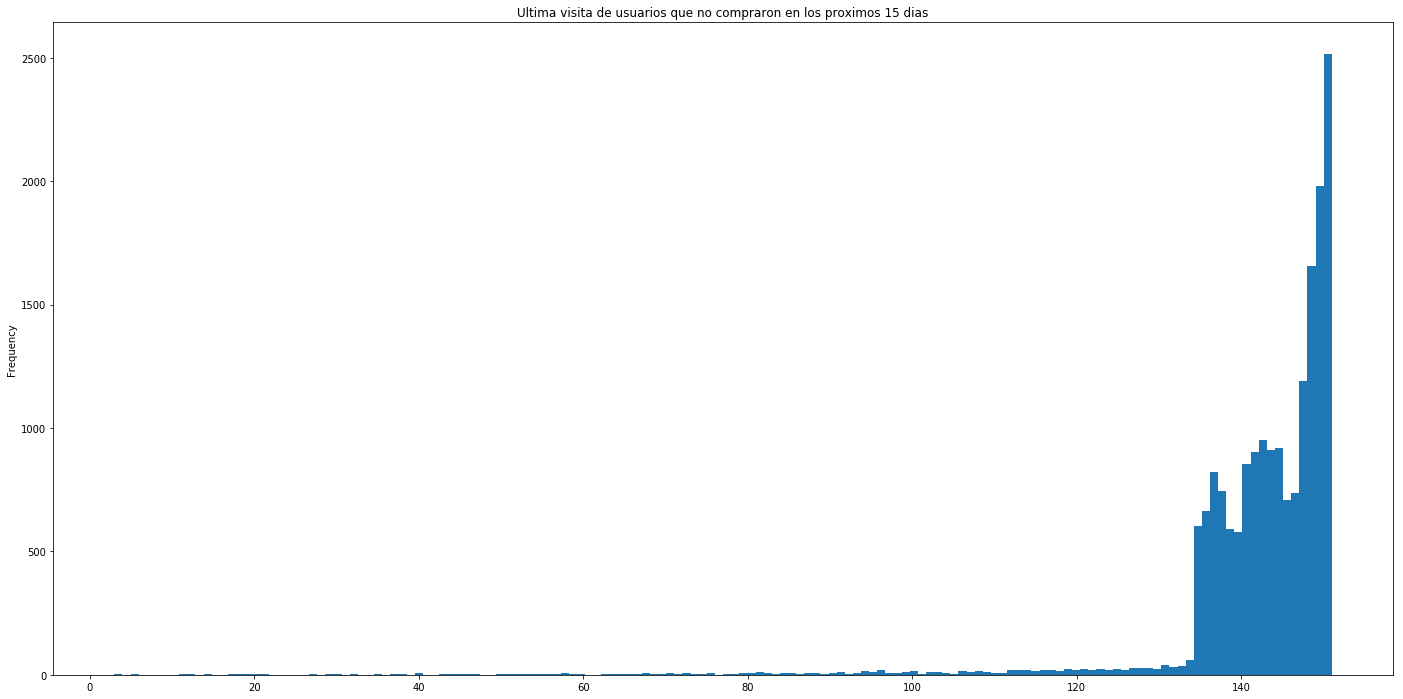

In [44]:
modelo[modelo['label']==0]['ultima_visita'].plot(kind='hist',figsize=(24,12),bins=150)
plt.title('Ultima visita de usuarios que no compraron en los proximos 15 dias')

### Usuarios cuya ultima visita es antes de mayo solo habian entrado una vez

In [45]:
modelo.loc[(modelo['ultima_visita']<120)&(modelo['label']==1)]['dias_distintos'].nunique() 

1

In [46]:
modelo.loc[(modelo['ultima_visita']<120)&(modelo['label']==0)]['dias_distintos'].nunique() 

1

### Cantidad de visitas por usuario

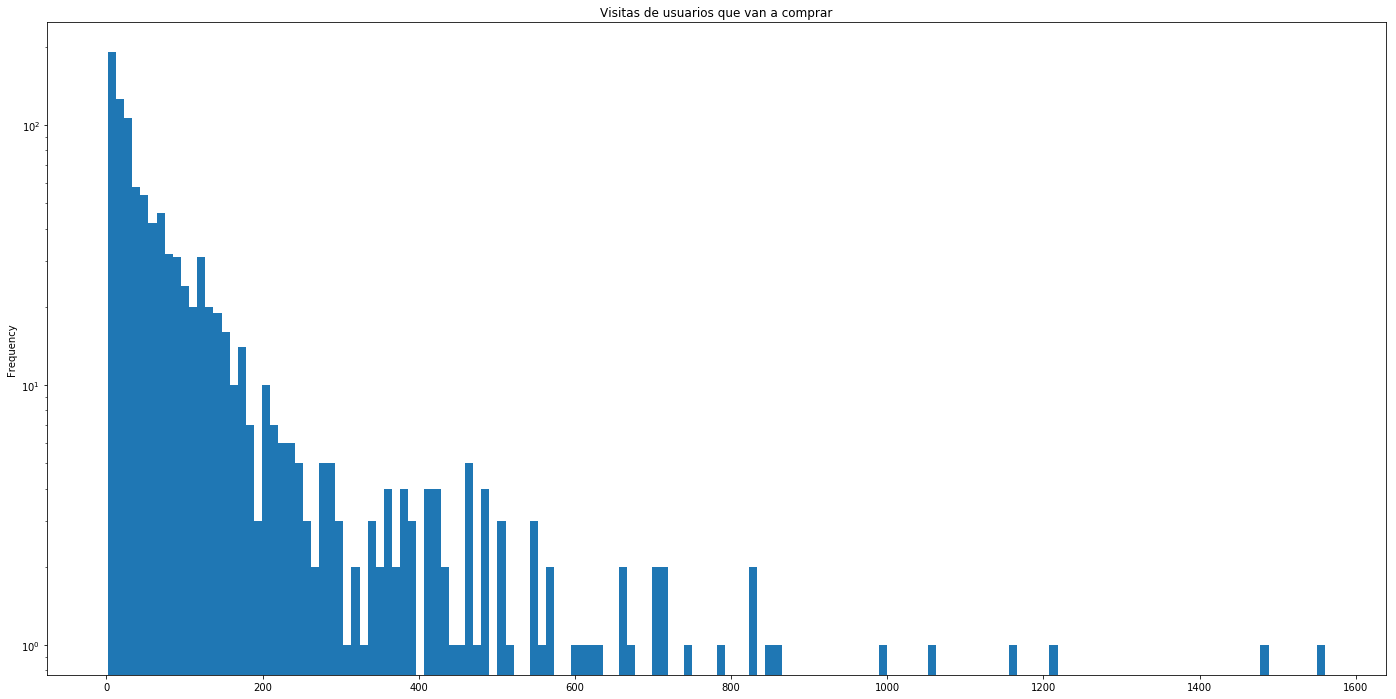

In [47]:
modelo[modelo['label']==1]['total_visitas_usuario'].plot(kind='hist',figsize=(24,12),bins=150)
plt.title('Visitas de usuarios que van a comprar')
plt.yscale('log', nonposy='clip')

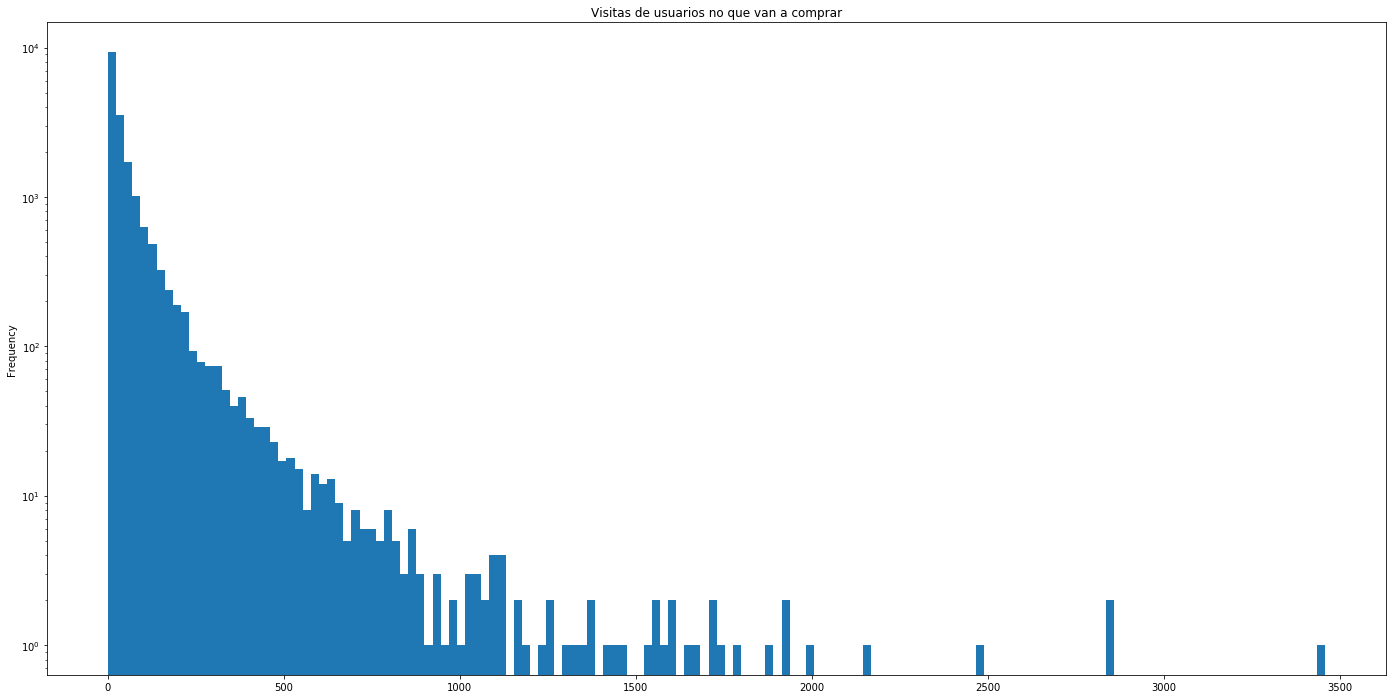

In [48]:
modelo[modelo['label']==0]['total_visitas_usuario'].plot(kind='hist',figsize=(24,12),bins=150)
plt.title('Visitas de usuarios no que van a comprar')
plt.yscale('log', nonposy='clip')

### Cantidad de visitas no decide si va a comprar o no

In [49]:
visitas={}
for i in range(100,3500,200):
    visitas[i]=[len(modelo.loc[(modelo['label']==0)&(modelo['total_visitas_usuario']>i)]),len(modelo.loc[(modelo['label']==1)&(modelo['total_visitas_usuario']>i)])]
visitas=pd.DataFrame(visitas)
visitas

,100,300,500,700,900,1100,1300,1500,1700,1900,2100,2300,2500,2700,2900,3100,3300
0,2635,545,208,106,59,43,28,21,13,8,5,4,3,3,1,1,1
1,280,78,33,16,6,4,2,1,0,0,0,0,0,0,0,0,0


### Cantidad de usuarios que visitaron por ultima vez la pagina antes de mayo, y realizaron una compra en los proximos 15 dias

In [50]:
len(modelo.loc[(modelo['ultima_visita']<120)&(modelo['label']==1)]) 

153

In [51]:
len(modelo.loc[(modelo['ultima_visita']<120)&(modelo['label']==0)]) 

673

### Cantidad de usuarios que visitaron por ultima vez la pagina en de mayo, y realizaron una compra en los proximos 15 dias

In [52]:
len(modelo.loc[(modelo['ultima_visita']>119)&(modelo['label']==1)]) 

827

In [53]:
len(modelo.loc[(modelo['ultima_visita']>119)&(modelo['label']==0)]) 

17761

### Usuarios que van a comprar tienen mayor promedio de modelos vistos

In [54]:
modelo[modelo['label']==1]['modelos_distintos_vistos'].mean(),modelo[modelo['label']==0]['modelos_distintos_vistos'].mean()

(8.989795918367347, 5.543723554301834)

### Promedio de usuarios que van a comprar es mayor si ingresaron a traves de una campaña 

In [55]:
modelo[modelo['label']==1]['campaña_ultima_semana'].mean(),modelo[modelo['label']==0]['campaña_ultima_semana'].mean()

(1.8622448979591837, 1.5189866550938482)

### Un 0.44% de las personas que van a comprar entraron a traves de una campaña

In [56]:
len(modelo.loc[(modelo['label']==1)&(modelo['campaña_ultima_semana']!=0)]),len(modelo.loc[(modelo['label']==0)&(modelo['campaña_ultima_semana']!=0)] )

(432, 8076)

In [57]:
100*len(modelo.loc[(modelo['label']==1)&(modelo['campaña_ultima_semana']!=0)]) /len(modelo[modelo['label']==1]),100*len(modelo.loc[(modelo['label']==0)&(modelo['campaña_ultima_semana']!=0)]) /len(modelo[modelo['label']==0])

(44.08163265306123, 43.81035043940545)

De las 432, 90 (20%) ya habian comprado. O mejor dicho, un 80% que no habia comprado, a traves de una campaña despues terminó comprando.

In [58]:
len(modelo.loc[(modelo['label']==1)&(modelo['campaña_ultima_semana']!=0)&(modelo['total_compras']!=0)])

90

### Un 20% de usuarios que van a comprar, ya lo habian hecho

In [59]:
len(modelo.loc[(modelo['label']==1)&(modelo['total_compras']>0)]), 100*len(modelo.loc[(modelo['label']==1)&(modelo['total_compras']>0)])/len(modelo[modelo['label']==1])

(197, 20.102040816326532)

Text(0.5, 1.0, 'Frecuencia de compras anteriores de usuarios que van a comprar')

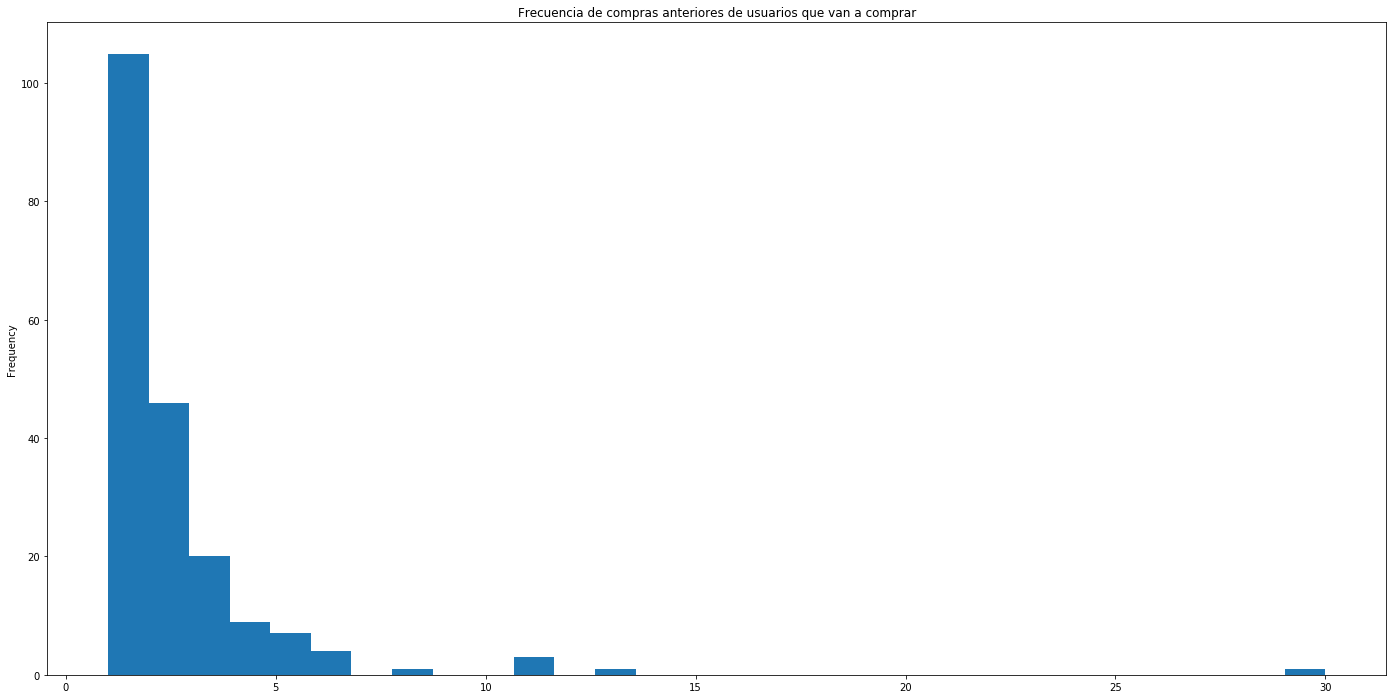

In [60]:
modelo.loc[(modelo['label']==1)&(modelo['total_compras']>0)]['total_compras'].plot(kind='hist',figsize=(24,12),bins=30)
plt.title('Frecuencia de compras anteriores de usuarios que van a comprar')

28 (2.8%) usuarios ya habian comprado antes de mayo. 

In [61]:
len(modelo.loc[(modelo['label']==1)&(modelo['total_compras']>0)&(modelo['ultima_visita']<120)])

28

Pero estos usuarios tenian una media de 129 visitas a la pagina

In [62]:
modelo.loc[(modelo['label']==1)&(modelo['total_compras']>0)&(modelo['ultima_visita']<120)]['total_visitas_usuario'].mean()

129.46428571428572

De los otros 169, su media de visitas a la pagina es de 240! Esto demuestra una tendencia a comprar.

In [63]:
modelo.loc[(modelo['label']==1)&(modelo['total_compras']>0)&(modelo['ultima_visita']>120)]['total_visitas_usuario'].mean()

240.92857142857142

Y su media de dias distintos es mayor a 6.

In [64]:
modelo.loc[(modelo['label']==1)&(modelo['total_compras']>0)&(modelo['ultima_visita']>120)]['dias_distintos'].mean()

6.232142857142857

141 es la media de aquellos que ya habian comprado, pero no lo hicieron luego.

In [65]:
modelo.loc[(modelo['label']==0)&(modelo['total_compras']>0)&(modelo['ultima_visita']>120)]['total_visitas_usuario'].mean()

141.05061983471074

Y para estos, la media de dias distintos es 5.

In [66]:
modelo.loc[(modelo['label']==0)&(modelo['total_compras']>0)&(modelo['ultima_visita']>120)]['dias_distintos'].mean()

5.037706611570248

## MACHINE LEARNING

In [67]:
##Ahora empieza ML

from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,roc_auc_score

## Split

In [68]:
X = modelo.drop(['person','label'], axis=1)
y = modelo['label']

## K-means

In [69]:
from sklearn.cluster import KMeans

In [70]:
kmeans_2 = KMeans(n_clusters=2, init='k-means++', n_jobs=8).fit(X)
X['kmeans_2'] = kmeans_2.labels_

In [71]:
kmeans_3 = KMeans(n_clusters=3, init='k-means++', n_jobs=8).fit(X)
X['kmeans_3'] = kmeans_3.labels_

In [72]:
kmeans_4 = KMeans(n_clusters=4, init='k-means++', n_jobs=8).fit(X)
X['kmeans_4'] = kmeans_4.labels_

In [73]:
kmeans_5 = KMeans(n_clusters=5, init='k-means++', n_jobs=8).fit(X)
X['kmeans_5'] = kmeans_5.labels_

In [74]:
kmeans_50 = KMeans(n_clusters=50, init='k-means++', n_jobs=8).fit(X)
X['kmeans_50'] = kmeans_50.labels_

In [75]:
kmeans_100 = KMeans(n_clusters=100, init='k-means++', n_jobs=8).fit(X)
X['kmeans_100'] = kmeans_100.labels_

## HDBScan

In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=100)
cluster_labels = clusterer.fit_predict(X)
X['HDBScan'] = cluster_labels

## Feature importance con random forest

Feature ranking:
1. feature 30 (0.065091)
2. feature 16 (0.055385)
3. feature 3 (0.052254)
4. feature 29 (0.050244)
5. feature 15 (0.029129)
6. feature 17 (0.026925)
7. feature 45 (0.026687)
8. feature 22 (0.026584)
9. feature 39 (0.025932)
10. feature 26 (0.025503)
11. feature 14 (0.025095)
12. feature 38 (0.024397)
13. feature 18 (0.024312)
14. feature 0 (0.024090)
15. feature 7 (0.023905)
16. feature 20 (0.023841)
17. feature 19 (0.023654)
18. feature 2 (0.023653)
19. feature 5 (0.023332)
20. feature 24 (0.023328)
21. feature 37 (0.023298)
22. feature 25 (0.022644)
23. feature 44 (0.022612)
24. feature 10 (0.022466)
25. feature 1 (0.022303)
26. feature 36 (0.022173)
27. feature 12 (0.021067)
28. feature 28 (0.020672)
29. feature 31 (0.020369)
30. feature 11 (0.019820)
31. feature 27 (0.018594)
32. feature 8 (0.018473)
33. feature 13 (0.017603)
34. feature 21 (0.017522)
35. feature 23 (0.015614)
36. feature 43 (0.010659)
37. feature 4 (0.009346)
38. feature 42 (0.009342)
39. feature 

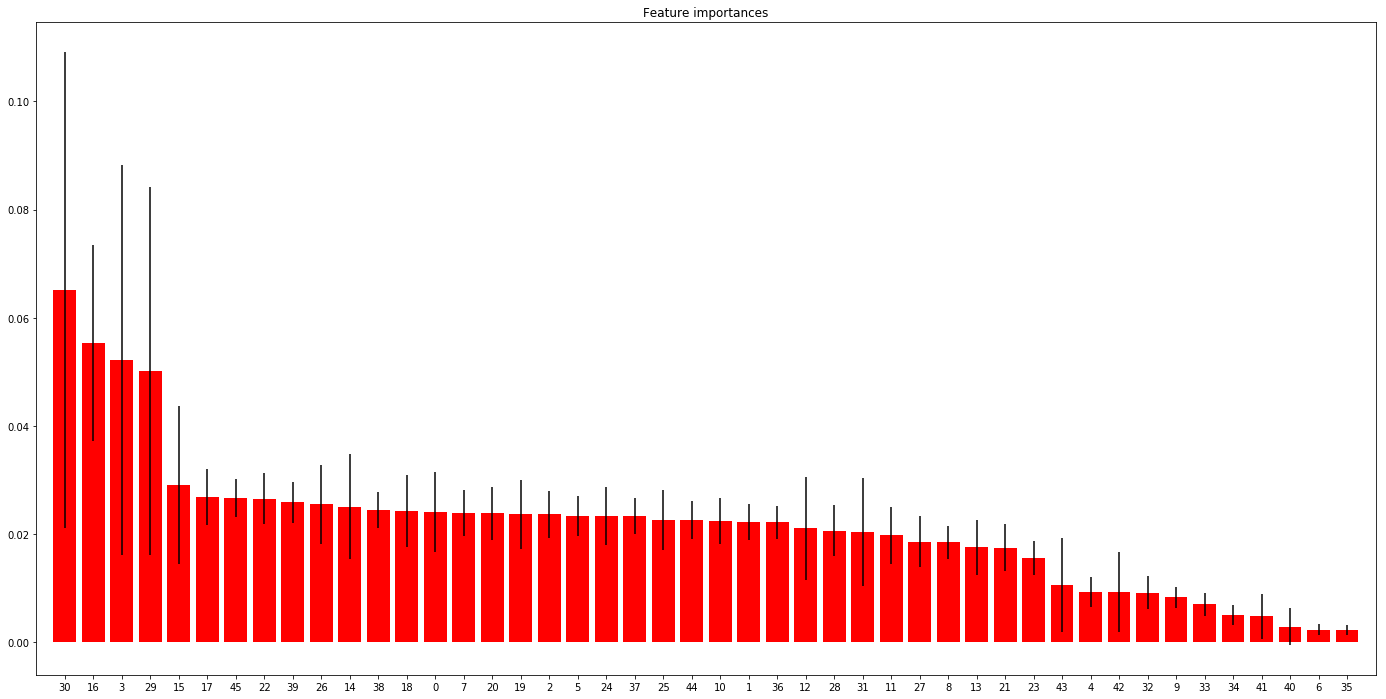

In [76]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
forest = ExtraTreesClassifier(n_estimators=500,
                              random_state=0,
                             class_weight ={1:8})
forest.fit(X, y)
def feature_importance(clasificador):
    importances = clasificador.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clasificador.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    plt.figure(figsize=(24,12))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
feature_importance(forest)


## Select k best features

In [77]:
from sklearn.feature_selection import SelectKBest
model= SelectKBest(k='all').fit(X,y)
columnas=list(X.columns[model.get_support()])
columnas

['horas_distintas',
 'ad campaign hit',
 'brand listing',
 'checkout',
 'conversion',
 'generic listing',
 'lead',
 'search engine hit',
 'searched products',
 'staticpage',
 'viewed product',
 'visited site',
 'dias_distintos',
 'dias_distintos_ultima_semana',
 'dias_distintos_de_la_semana',
 'dias_distintos_de_la_semana_last_month',
 'ultima_visita',
 'compras_por_dia_semana',
 'modelos_distintos_vistos',
 'marcas_distintas',
 'celular_mas_visto',
 'modelos_por_color',
 'eventos_distintos',
 'campaña_ultima_semana',
 'total_visitas_usuario',
 'visitas_ultimo_mes',
 'visitas_ultimos_15',
 'visitas_ultima_semana',
 'visitas_ultimos_3',
 'total_checkout',
 'checkouts_ultimo_mes',
 'checkouts_ultima_semana',
 'total_compras',
 'compras_ultimo_mes',
 'compras_ultima_semana',
 'subscripciones',
 'precio_max',
 'precio_mean',
 'precio_std',
 'precio_min',
 'kmeans_2',
 'kmeans_3',
 'kmeans_4',
 'kmeans_5',
 'kmeans_50',
 'kmeans_100']

In [78]:
model=model.transform(X)

In [79]:
X = pd.DataFrame.from_records(model)
X.columns=columnas

In [80]:
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2) 

In [82]:
len(X_train),len(X_test),len(y_train),len(y_test)

(19414, 0, 19414, 0)

In [83]:
X_train.head()

,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,total_compras,compras_ultimo_mes,compras_ultima_semana,subscripciones,precio_max,precio_mean,precio_std,precio_min,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_50,kmeans_100
14137,3,0,0,5,0,0,0,0,1,0,2,0,1,0,2,1,141,10280,3,1,3,1,3,0,8,2,2,0,0,5,2,0,0,0,0,0,3009,1884,1027,619,0,0,0,0,44,74
16128,1,1,0,4,0,0,0,0,0,0,1,1,1,1,1,1,148,6055,1,1,5,0,4,1,7,7,7,7,7,4,4,4,0,0,0,0,1275,1275,0,1275,0,0,0,0,8,4
11749,1,0,2,0,0,0,0,2,0,0,0,1,0,0,1,0,72,6975,0,0,0,0,3,0,5,0,0,0,0,0,0,0,0,0,0,0,1275,1275,0,1275,0,0,0,0,44,99
9119,1,0,0,0,0,2,0,2,0,0,0,1,0,0,1,0,106,4325,0,0,0,0,3,0,5,0,0,0,0,0,0,0,0,0,0,0,1275,1275,0,1275,0,0,0,0,8,97
13115,4,4,0,1,0,4,0,0,22,0,20,3,1,1,1,1,144,76950,4,1,12,0,6,4,54,54,54,54,0,1,1,1,0,0,0,0,1499,1135,252,319,0,0,0,0,6,90


In [84]:
y_train.head()

28380    0
32351    0
23680    0
18450    0
26423    0
Name: label, dtype: int32

### Graficador del ROC AUC 

In [85]:
from sklearn.metrics import roc_curve, auc
def graficar_roc(clasificador):
    fpr = dict()
    tpr = dict()
    fpr, tpr, _ = roc_curve(y_test, clasificador.predict_proba(X_test)[:,1])
    roc_auc = dict()
    roc_auc = auc(fpr, tpr)

    # make the plot
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc), linewidth =3)        
    plt.legend(loc="lower right", shadow=True, fancybox =True) 
    plt.show()

## Algoritmos de clasificación

## XGBOOST

In [86]:
my_classifier1 = xgb.XGBClassifier(objective ='binary:logistic',max_depth =1,learning_rate = 0.02, n_estimators = 500,scale_pos_weight=7)
my_classifier1.fit(X_train,y_train)
predictions=my_classifier1.predict(X_test)
metrics.confusion_matrix(y_test, predictions)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=7, seed=None,
       silent=True, subsample=1)

In [87]:
accuracy_score(y_test, predictions),roc_auc_score(y_test,  my_classifier1.predict_proba(X_test)[:,1])

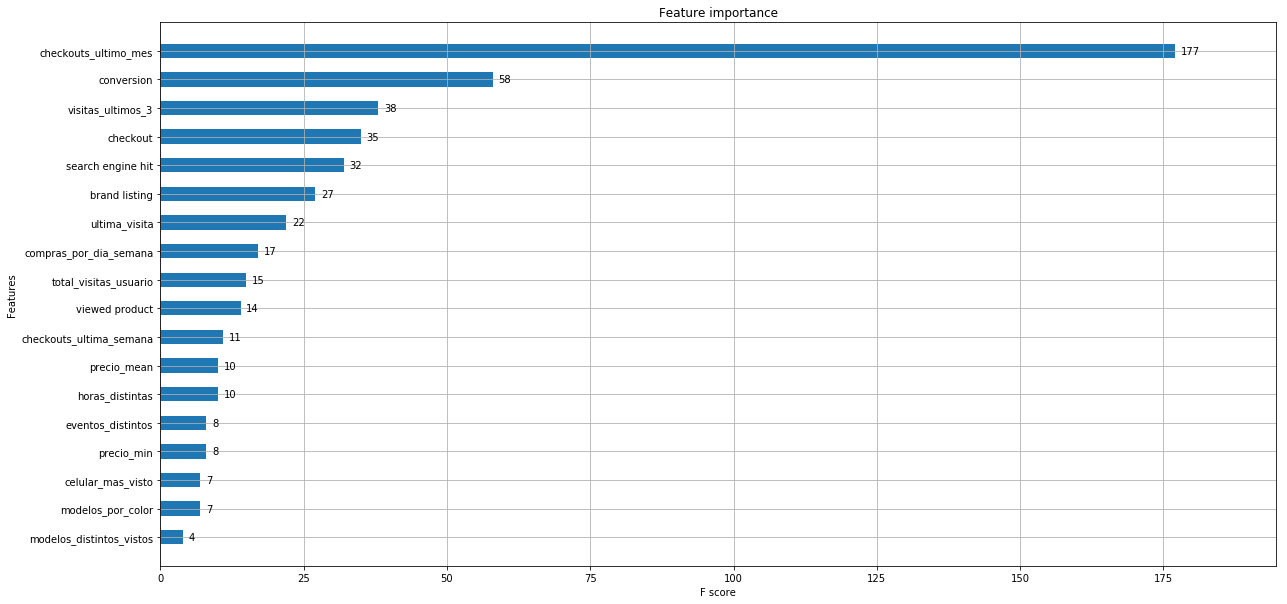

In [88]:
from xgboost import plot_importance
ax = plot_importance(my_classifier1,height=0.5)
fig = ax.figure
fig.set_size_inches(20,10)
plt.show()

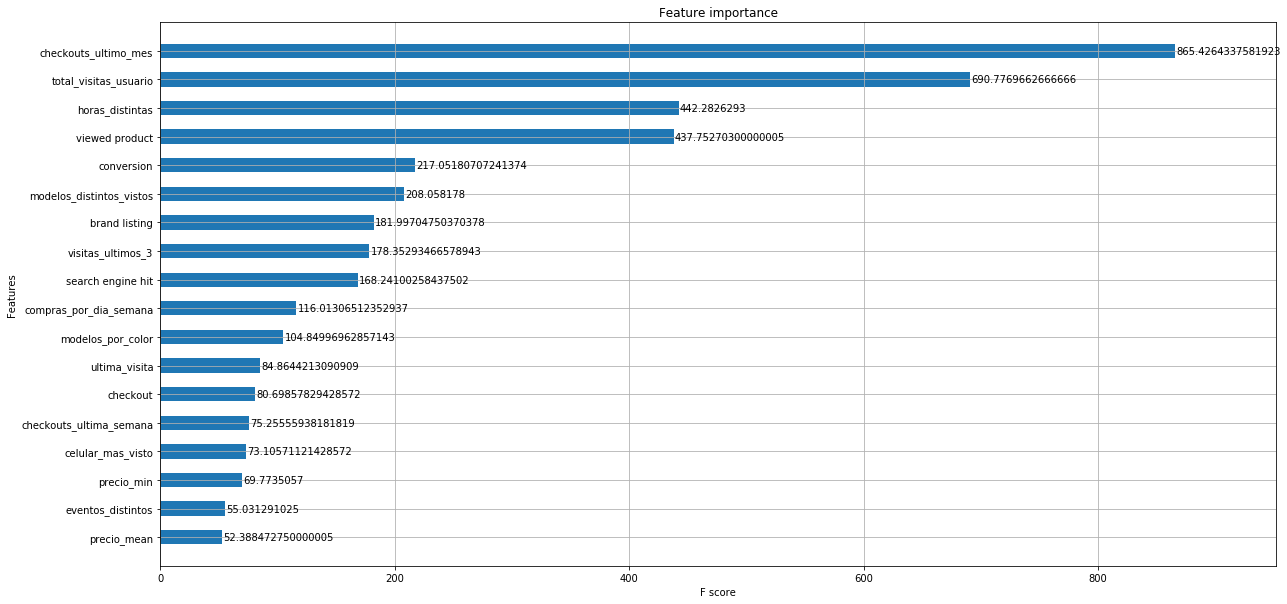

In [89]:
ax = plot_importance(my_classifier1,height=0.5,importance_type='gain')
fig = ax.figure
fig.set_size_inches(20,10)
plt.show()

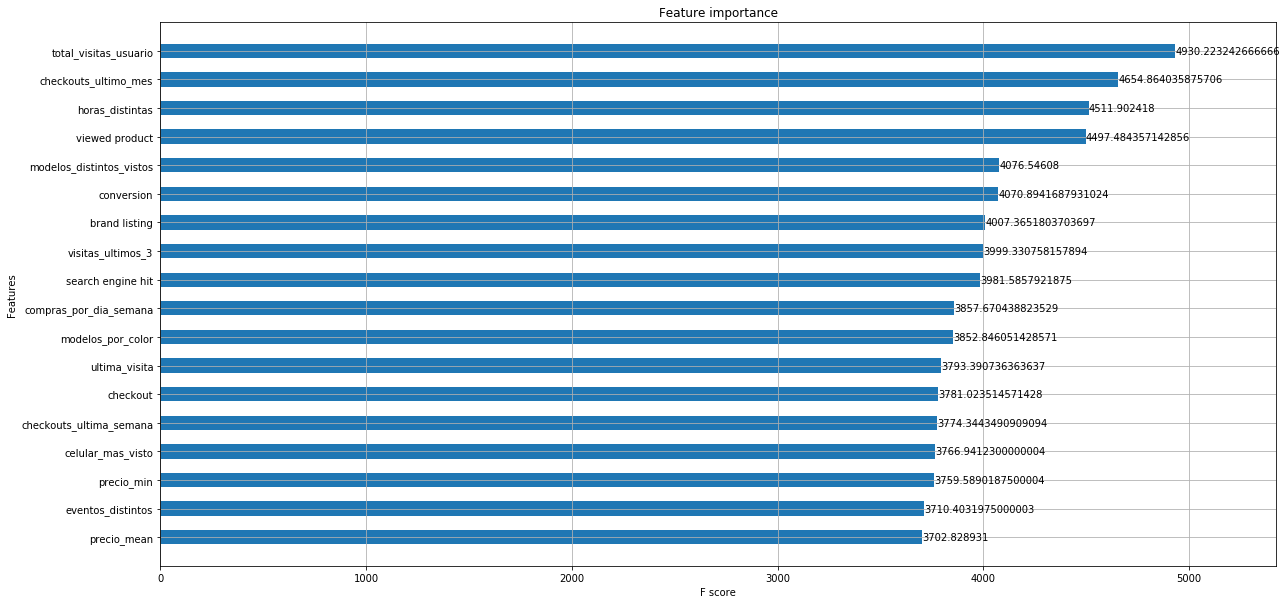

In [90]:
ax = plot_importance(my_classifier1,height=0.5,importance_type='cover')
fig = ax.figure
fig.set_size_inches(20,10)
plt.show()

In [92]:
graficar_roc(my_classifier1)

## LightGBM

In [93]:
import lightgbm as lgb
my_classifier2 = lgb.LGBMClassifier(   
        objective='binary',
        boosting='goss',
        scale_pos_weight=8,
        n_estimators=13000,
        learning_rate=0.001,
        max_depth=1, 
        num_threads =6,        
    )

my_classifier2.fit(X_train,y_train)
predictions=my_classifier2.predict(X_test)
metrics.confusion_matrix(y_test, predictions)

LGBMClassifier(boosting='goss', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, importance_type='split', learning_rate=0.001,
        max_depth=1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=13000, n_jobs=-1, num_leaves=31,
        num_threads=6, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=8, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [94]:
accuracy_score(y_test, predictions),roc_auc_score(y_test,  my_classifier2.predict_proba(X_test)[:,1])

In [95]:
graficar_roc(my_classifier2)

## RANDOM FOREST

In [96]:
from sklearn.ensemble import RandomForestClassifier #a mayor depth, mas precisos los 0, menos los 1,class weight cambia mucho
my_classifier3 = RandomForestClassifier(criterion= 'entropy',max_depth= 5,n_estimators=1000, max_features= 'auto', class_weight={1:9} ,n_jobs=-1)
my_classifier3.fit(X_train,y_train)
predictions=my_classifier3.predict(X_test)
metrics.confusion_matrix(y_test, predictions)

RandomForestClassifier(bootstrap=True, class_weight={1: 9},
            criterion='entropy', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [97]:
accuracy_score(y_test, predictions),roc_auc_score(y_test,  my_classifier3.predict_proba(X_test)[:,1])

In [98]:
graficar_roc(my_classifier3)

In [99]:
feature_importance(my_classifier3)

## Cat Boost

In [100]:
from catboost import CatBoostClassifier
my_classifier4=CatBoostClassifier(class_weights=[1, 8] ,logging_level='Silent',thread_count=6,boosting_type='Ordered',loss_function='Logloss',depth=3,leaf_estimation_method ='Newton',
                                 l2_leaf_reg = 23,od_pval=0.0000001)
my_classifier4.fit(X_train,y_train)
predictions=my_classifier4.predict(X_test)
metrics.confusion_matrix(y_test, predictions)

In [101]:
accuracy_score(y_test, predictions),roc_auc_score(y_test,  my_classifier4.predict_proba(X_test)[:,1])

y_pred=0.0
for i in range(10):
    clf=CatBoostClassifier(class_weights=[1, 8] ,logging_level='Silent',thread_count=6,boosting_type='Ordered',loss_function='Logloss',depth=3,leaf_estimation_method ='Newton',
                                 l2_leaf_reg = 23,od_pval=0.0000001,random_seed=i+200)
    fit_model = clf.fit(X_train,y_train)
    y_pred +=  fit_model.predict_proba(X_test)[:,1]
y_pred /= 10

In [102]:
graficar_roc(my_classifier4)

## Voting classifier

In [103]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[  ('XGB', my_classifier1), ('GBM', my_classifier2),('RF', my_classifier3),('CB', my_classifier4)], voting='soft', n_jobs =-1)
vclf = vclf.fit(X_train, y_train)
predictions = vclf.predict(X_test)
metrics.confusion_matrix(y_test, predictions)

In [104]:
accuracy_score(y_test, predictions),roc_auc_score(y_test,  vclf.predict_proba(X_test)[:,1])

In [105]:
graficar_roc(vclf)

## KAGGLE PREDICTIONS

In [106]:
kaggle= pd.read_csv('data/kaggle.csv',low_memory=False)
kaggle=pd.merge(kaggle, a_predecir, on='person', how='inner')

In [107]:
kaggle2=kaggle.loc[:,columnas]
kaggle2 = kaggle2.fillna(0)
kaggle2.head()

d:\programas\python\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,total_compras,compras_ultimo_mes,compras_ultima_semana,subscripciones,precio_max,precio_mean,precio_std,precio_min,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_50,kmeans_100
0,1,0,0,1,0,1,0,1,1,0,4,1,1,0,1,1,138,8046,1,1,5,0,6,0,9,9,9,0,0,1,1,0,0,0,0,0,1275,972,287,730,0.0,0.0,0.0,0.0,0.0,0.0
1,22,29,4,7,0,21,1,0,6,0,404,95,15,4,7,6,148,618857,15,3,219,1,8,1,567,173,126,53,8,7,2,0,0,0,0,1,3009,1406,448,619,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,5,1,0,1,0,2,1,0,13,2,2,1,2,2,147,16460,3,2,6,0,8,1,26,26,26,16,0,1,1,1,0,0,0,0,2469,1550,512,1275,0.0,0.0,0.0,0.0,0.0,0.0
3,13,15,7,1,0,20,0,26,1,5,739,22,13,4,6,6,151,924152,57,7,253,1,9,5,836,836,449,270,252,1,1,0,0,0,0,0,2099,1184,213,379,0.0,0.0,0.0,0.0,0.0,0.0
4,11,14,8,2,0,14,0,13,9,0,177,20,5,0,5,5,142,198938,9,2,84,1,8,0,257,257,257,0,0,2,2,0,0,0,0,0,2469,1311,457,550,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
kmeans_2 = KMeans(n_clusters=2, init='k-means++', n_jobs=8).fit(kaggle2)
kaggle2['kmeans_2'] = kmeans_2.labels_
kmeans_3 = KMeans(n_clusters=3, init='k-means++', n_jobs=8).fit(kaggle2)
kaggle2['kmeans_3'] = kmeans_3.labels_
kmeans_4 = KMeans(n_clusters=4, init='k-means++', n_jobs=8).fit(kaggle2)
kaggle2['kmeans_4'] = kmeans_4.labels_
kmeans_5 = KMeans(n_clusters=5, init='k-means++', n_jobs=8).fit(kaggle2)
kaggle2['kmeans_5'] = kmeans_5.labels_

clusterer = hdbscan.HDBSCAN(min_cluster_size=100)
cluster_labels = clusterer.fit_predict(kaggle2)
kaggle2['HDBScan'] = cluster_labels

NameError: name 'hdbscan' is not defined

In [109]:
vclf = VotingClassifier(estimators=[  ('XGB', my_classifier1), ('GBM', my_classifier2),('RF', my_classifier3),('CB', my_classifier4)], voting='soft', n_jobs =-1)
vclf = vclf.fit(X, y)

In [110]:
predictions=vclf.predict_proba(kaggle2)

In [111]:
kaggle['prediction0'] = predictions[:,0]
kaggle['label'] = predictions[:,1]

In [112]:
kaggle.head(15)

,person,horas_distintas,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,dias_distintos,dias_distintos_ultima_semana,dias_distintos_de_la_semana,dias_distintos_de_la_semana_last_month,ultima_visita,compras_por_dia_semana,modelos_distintos_vistos,marcas_distintas,celular_mas_visto,modelos_por_color,eventos_distintos,campaña_ultima_semana,total_visitas_usuario,visitas_ultimo_mes,visitas_ultimos_15,visitas_ultima_semana,visitas_ultimos_3,total_checkout,checkouts_ultimo_mes,checkouts_ultima_semana,total_compras,compras_ultimo_mes,compras_ultima_semana,subscripciones,precio_max,precio_mean,precio_std,precio_min,label,prediction0
0,4886f805,1,0,0,1,0,1,0,1,1,0,4,1,1,0,1,1,138,8046,1,1,5,0,6,0,9,9,9,0,0,1,1,0,0,0,0,0,1275,972,287,730,0.059419,0.940581
1,0297fc1e,22,29,4,7,0,21,1,0,6,0,404,95,15,4,7,6,148,618857,15,3,219,1,8,1,567,173,126,53,8,7,2,0,0,0,0,1,3009,1406,448,619,0.230486,0.769514
2,2d681dd8,2,1,5,1,0,1,0,2,1,0,13,2,2,1,2,2,147,16460,3,2,6,0,8,1,26,26,26,16,0,1,1,1,0,0,0,0,2469,1550,512,1275,0.088926,0.911074
3,cccea85e,13,15,7,1,0,20,0,26,1,5,739,22,13,4,6,6,151,924152,57,7,253,1,9,5,836,836,449,270,252,1,1,0,0,0,0,0,2099,1184,213,379,0.284918,0.715082
4,4c8a8b93,11,14,8,2,0,14,0,13,9,0,177,20,5,0,5,5,142,198938,9,2,84,1,8,0,257,257,257,0,0,2,2,0,0,0,0,0,2469,1311,457,550,0.207422,0.792578
5,29ebb414,4,4,0,1,0,3,0,4,11,0,8,4,2,0,2,2,140,27474,3,1,7,0,7,0,35,35,35,0,0,1,1,0,0,0,0,0,2199,1415,330,1069,0.093924,0.906076
6,3dc1950f,15,3,6,3,0,25,0,7,2,1,595,30,11,2,5,5,149,819398,56,7,95,2,9,1,672,287,235,62,5,3,2,0,0,0,0,0,2869,1144,398,319,0.252772,0.747228
7,8ea4c165,8,13,5,3,0,8,0,9,17,0,97,7,3,0,4,3,139,176726,15,3,29,1,8,0,159,131,39,0,0,3,2,0,0,0,0,0,3559,1183,505,669,0.230671,0.769329
8,d8cfe234,4,0,4,3,1,1,0,2,8,0,39,4,4,0,4,4,142,63370,7,1,16,1,8,0,62,53,53,0,0,3,2,0,1,1,0,0,1275,916,342,439,0.232574,0.767426
9,d6bc64df,8,10,0,2,0,12,0,8,19,0,155,7,3,0,5,2,138,178459,13,3,70,0,7,0,213,98,86,0,0,2,1,0,0,0,0,0,2469,1185,315,319,0.194576,0.805424


In [113]:
kaggle[['person','label']].to_csv('predicciones5.csv', encoding='utf-8', index=False)